# Spatial and Temporal Crime Analysis in the United States (2025)

### Jose Miguel Martínez Martín – 2025

## 1. Introduction

This scientific notebook presents a comprehensive spatial and temporal analysis of crime incidents in the United States during the year 2025. The study is based on official geospatial data retrieved from the U.S. Government's open data portal [data.gov](https://catalog.data.gov/dataset/crime-incidents-in-2025), specifically from the "Crime Incidents in 2025" dataset maintained by the District of Columbia Metropolitan Police Department (MPD). This dataset comprises a subset of locations and attributes of incidents reported in the ASAP (Analytical Services Application) crime report database.

The dataset was processed using automated geocoding to align incidents with the District's Master Address Repository. Coordinates were assigned to the street block level, although a small number of points remain unassigned (defaulted to 0,0) due to geocoding limitations. Notably, starting February 1, 2020, the MPD adopted a new methodology to enhance geographical accuracy: ward, ANC, SMD, BID, neighborhood cluster, voting precinct, block group, and census tract values are now calculated prior to block-level anonymization. This methodological refinement has impacted approximately one percent of ward assignments, improving the spatial fidelity of the data for subsequent analysis.

In this publication, both exploratory and predictive data science methods are employed to uncover hidden structures and trends. Exploratory techniques are used to assess temporal distributions (e.g., by day of week, hour, and shift), and spatial clustering (using k-means) is applied to detect geographical hotspots of criminal activity. Furthermore, forecasting models (Holt-Winters Exponential Smoothing) and change point detection algorithms (Bayesian PELT method) are utilized to identify patterns over time and highlight significant shifts in incident trends.

This analysis aims to contribute to the growing body of research focused on urban crime modeling, geospatial intelligence, and data-driven approaches to public safety policy.


## 2. Data Loading and Preprocessing

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import folium
from folium.plugins import MarkerCluster
from matplotlib import cm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import ruptures as rpt
import matplotlib
from matplotlib import colormaps

file_path = r"Crime_Incidents_in_2025.geojson"
gdf = gpd.read_file(file_path)

## 3. Exploratory Data Analysis

### 3.1 Crime Distribution by Day of the Week

The chart below reveals an intriguing weekly rhythm in criminal activity, with noticeable peaks mid-week and a reduction over the weekend, suggesting a possible behavioral or enforcement-driven influence.

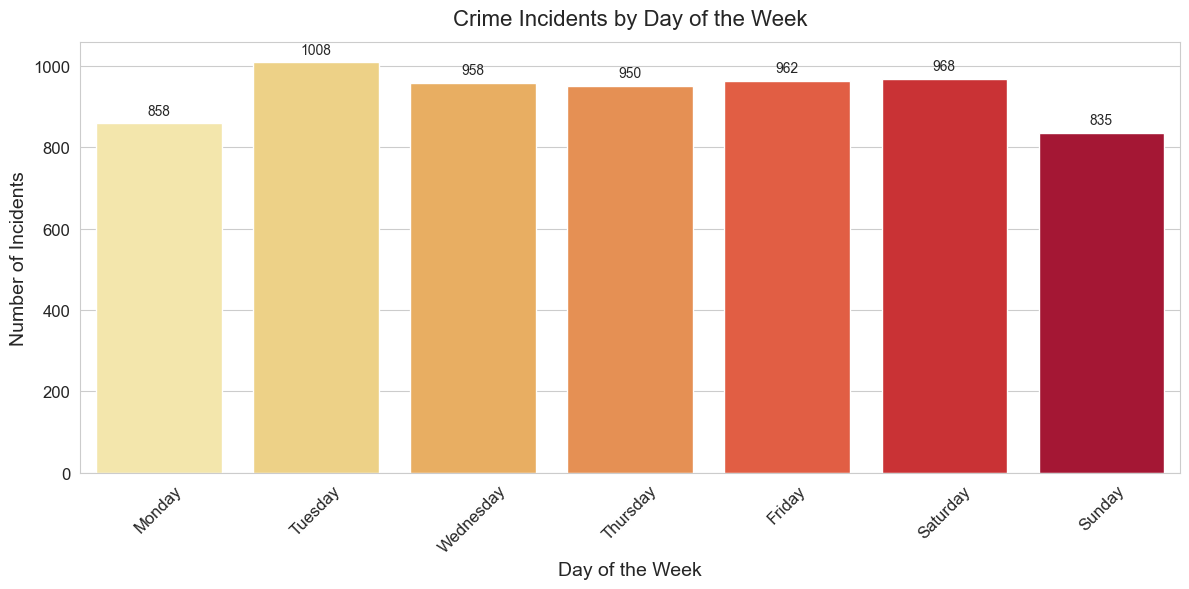

In [3]:
gdf["REPORT_DAT"] = pd.to_datetime(gdf["REPORT_DAT"])
gdf["report_day"]  = gdf["REPORT_DAT"].dt.day_name()
gdf["report_hour"] = gdf["REPORT_DAT"].dt.hour
gdf["report_day"] = pd.Categorical(
    gdf["report_day"],
    categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
    ordered=True
)

sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.countplot(
    data=gdf,
    x="report_day",
    hue="report_day",  
    palette="YlOrRd",
    legend=False       
)

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=4)

plt.title("Crime Incidents by Day of the Week", fontsize=16, pad=12)
plt.xlabel("Day of the Week", fontsize=14)
plt.ylabel("Number of Incidents", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

### 3.2 Crime Distribution by Hour of the Day

A closer look at the hourly distribution of crimes uncovers a pronounced concentration during late-night and early-evening hours, potentially reflecting both social dynamics and environmental vulnerability.

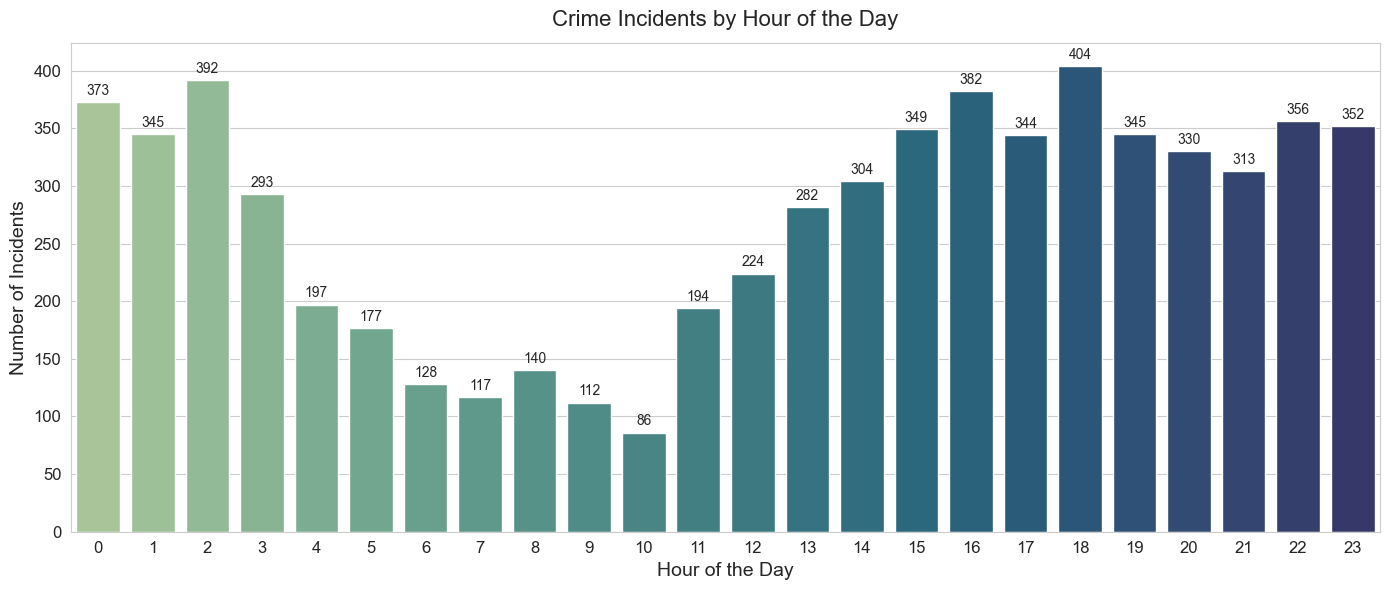

In [4]:
sns.set_style("whitegrid")
plt.figure(figsize=(14, 6))

ax = sns.countplot(
    data=gdf,
    x="report_hour",
    hue="report_hour",
    palette="crest",
    legend=False
)

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.title("Crime Incidents by Hour of the Day", fontsize=16, pad=12)
plt.xlabel("Hour of the Day", fontsize=14)
plt.ylabel("Number of Incidents", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


### 3.3 Crime Distribution by Shift

This heatmap vividly illustrates the intersection of time and day in shaping crime patterns, highlighting late evenings on weekdays as critical periods for incident spikes.

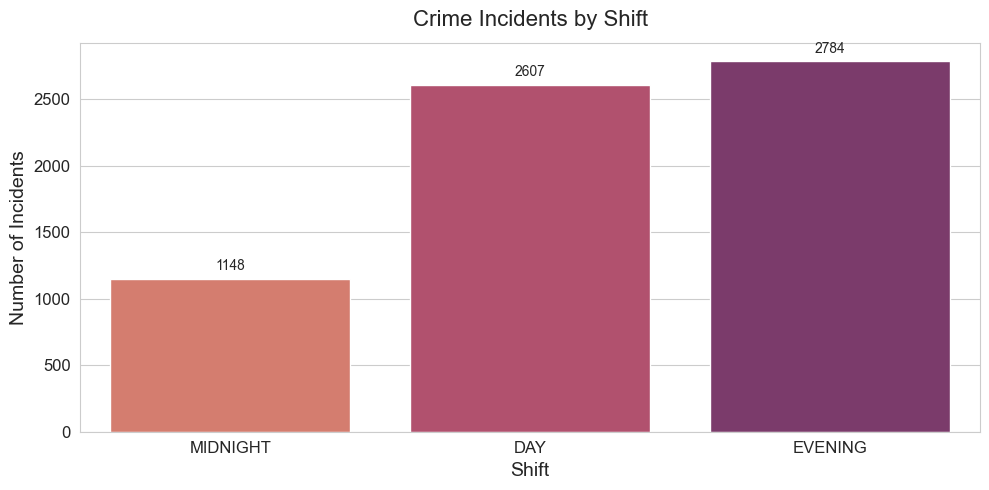

In [5]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))

ax = sns.countplot(
    data=gdf,
    x="SHIFT",
    hue="SHIFT",
    order=["MIDNIGHT", "DAY", "EVENING"],
    palette="flare",
    legend=False
)

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=4)

plt.title("Crime Incidents by Shift", fontsize=16, pad=12)
plt.xlabel("Shift", fontsize=14)
plt.ylabel("Number of Incidents", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

### 3.4 Heatmap: Day vs Hour Correlation

Shift-based data presents a compelling story: the evening shift appears to shoulder a disproportionate share of criminal reports, hinting at nocturnal activity surges or improved detection at these hours.

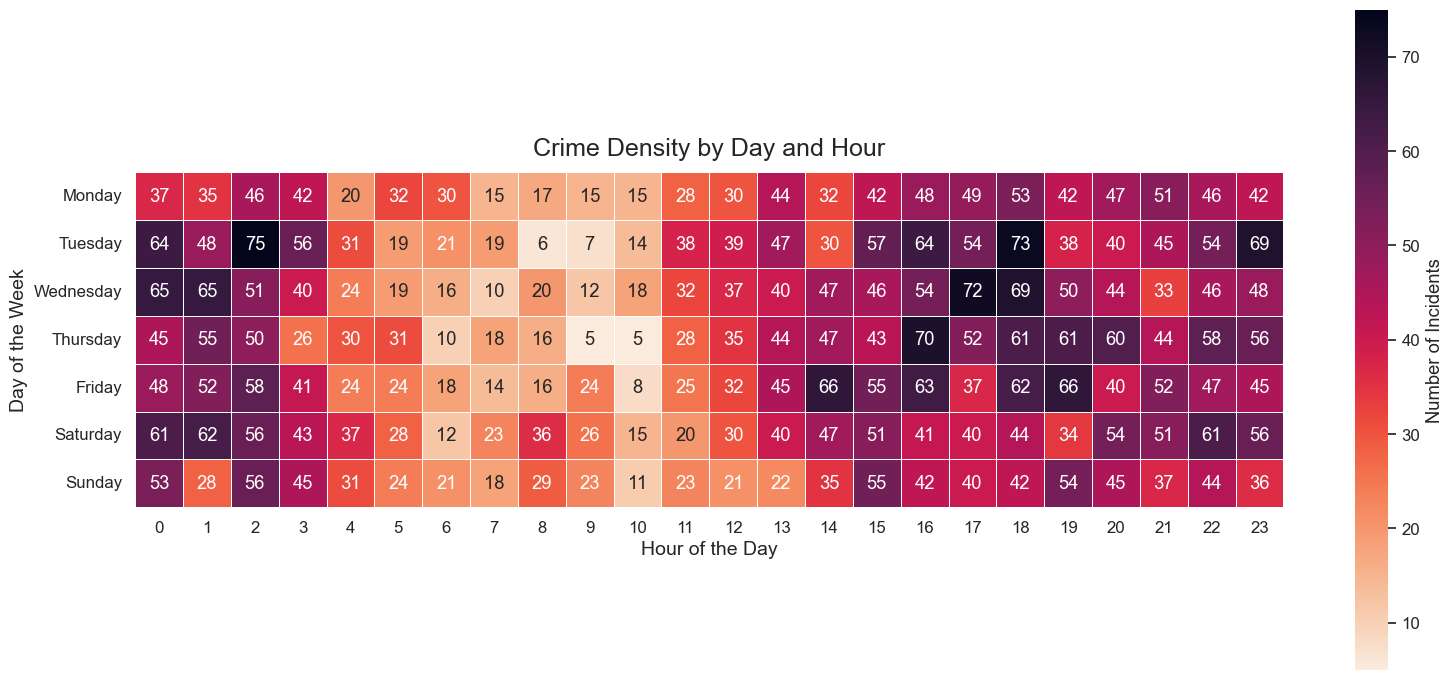

In [6]:
pivot = gdf.pivot_table(index="report_day", columns="report_hour", aggfunc="size", fill_value=0, observed=False)

plt.figure(figsize=(16, 7))
sns.set(font_scale=1.1)
ax = sns.heatmap(
    pivot,
    cmap="rocket_r",
    linewidths=0.4,
    linecolor="white",
    cbar_kws={"label": "Number of Incidents"},
    square=True,
    annot=True,
    fmt="d"
)

plt.title("Crime Density by Day and Hour", fontsize=18, pad=12)
plt.xlabel("Hour of the Day", fontsize=14)
plt.ylabel("Day of the Week", fontsize=14)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



## 4. Time Series Forecasting

### 4.1 Daily Crime Forecast Using Holt-Winters Method

Temporal forecasting suggests consistent crime volume with periodic fluctuations, yet the model anticipates a subtle upward trend — a signal worth monitoring in future policy discussions.

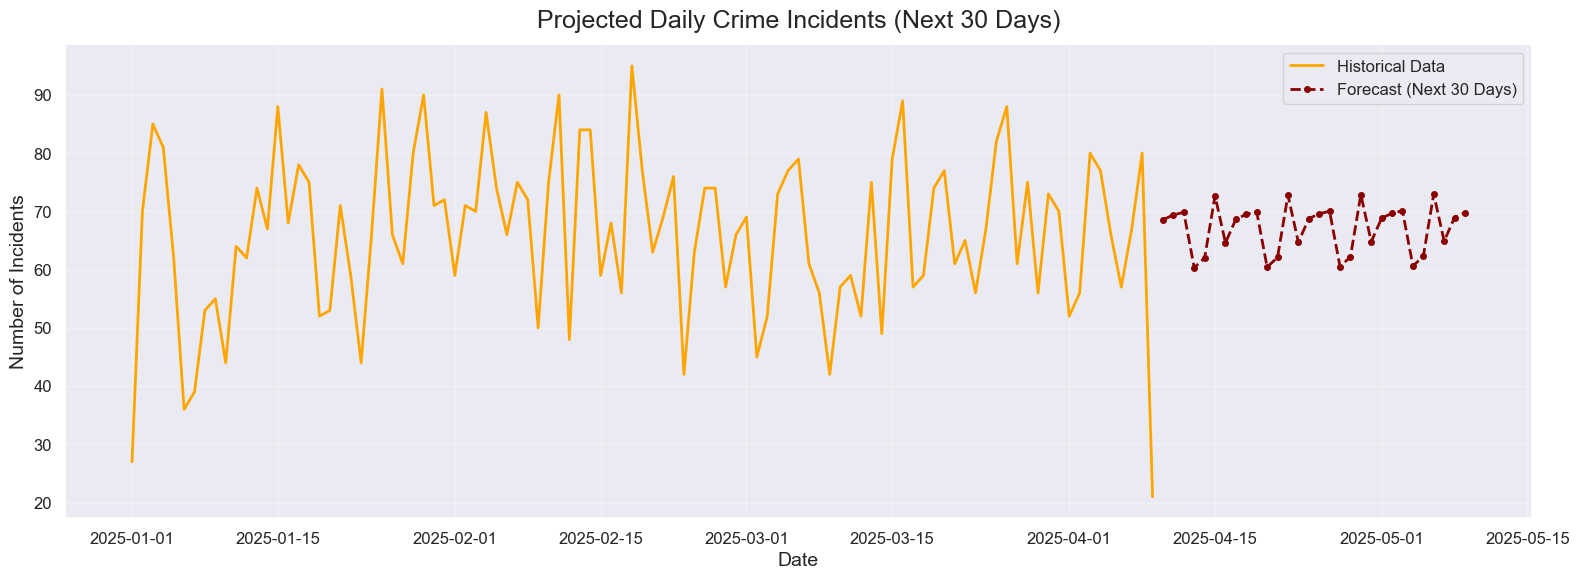

In [7]:
daily_crimes = gdf["REPORT_DAT"].dt.date.value_counts().sort_index()
ts = pd.Series(daily_crimes.values, index=pd.to_datetime(daily_crimes.index))
ts = ts.asfreq("D").fillna(0)

model = ExponentialSmoothing(ts, trend="add", seasonal="add", seasonal_periods=7)
fit = model.fit()
forecast = fit.forecast(30)

plt.figure(figsize=(16, 6))
plt.plot(ts, label="Historical Data", color="#FFA500", linewidth=2)
plt.plot(forecast, label="Forecast (Next 30 Days)", linestyle="--", color="#8B0000", linewidth=2, marker='o', markersize=4)

plt.title("Projected Daily Crime Incidents (Next 30 Days)", fontsize=18, pad=12)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Number of Incidents", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(frameon=True, fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 5. Geospatial Crime Clustering

### 5.1 Optimal Number of Clusters (Elbow Method)

The elbow curve points to an optimal clustering around k=4 or k=5, where additional clusters yield diminishing returns in variance explanation — a sweet spot for spatial segmentation.

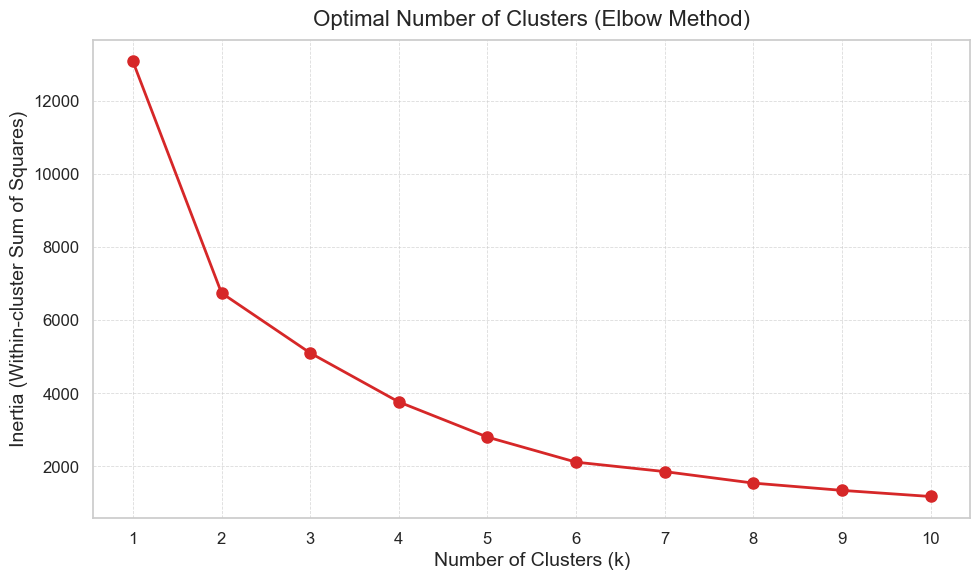

In [11]:
inertia = []
coords = gdf[["LATITUDE", "LONGITUDE"]].values
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(coords_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
plt.plot(K_range, inertia, marker='o', markersize=8, linewidth=2, color="#d62728")
plt.title("Optimal Number of Clusters (Elbow Method)", fontsize=16, pad=10)
plt.xlabel("Number of Clusters (k)", fontsize=14)
plt.ylabel("Inertia (Within-cluster Sum of Squares)", fontsize=14)
plt.xticks(K_range, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle="--", linewidth=0.6, alpha=0.7)
plt.tight_layout()
plt.show()

### 5.2 K-Means Clustering

Geospatial clustering uncovers multiple dense hotspots, revealing specific urban zones where law enforcement could benefit from enhanced presence or predictive resource allocation.

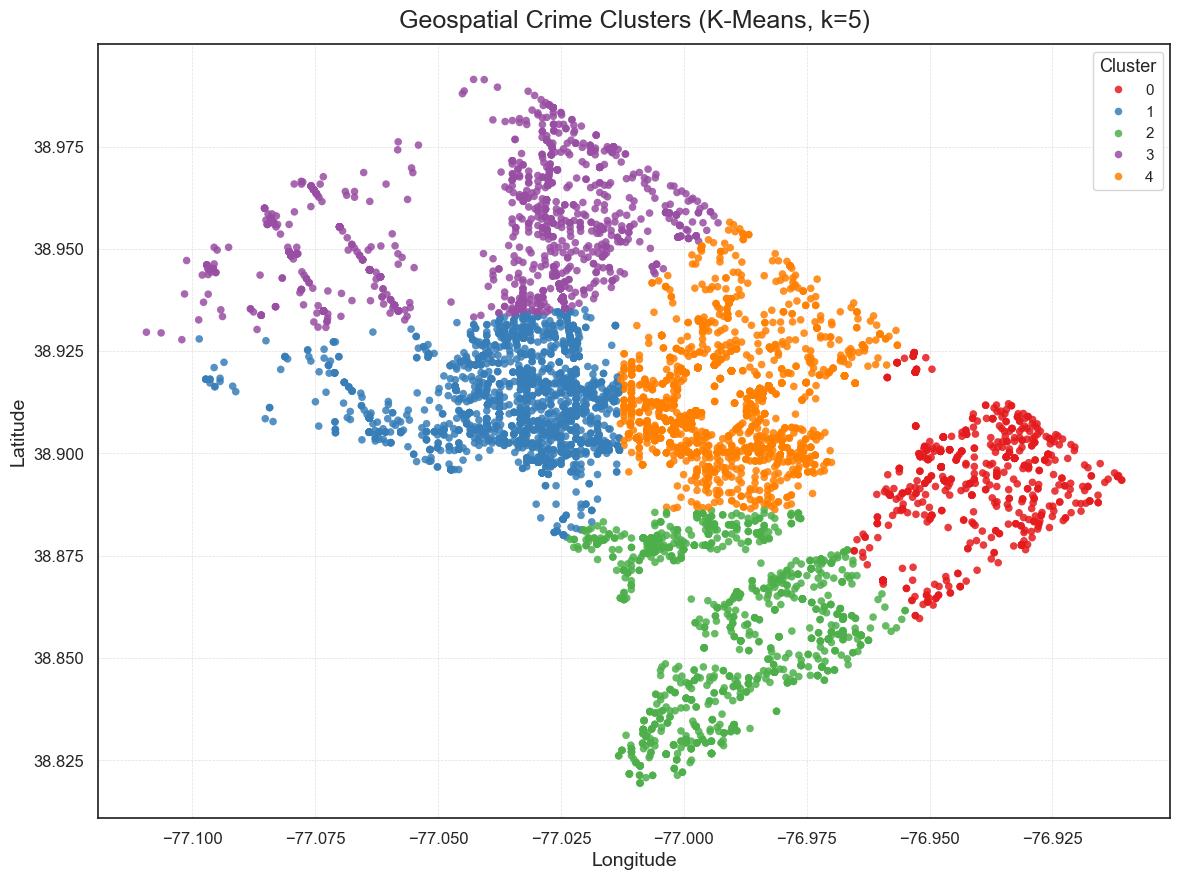

In [9]:
gdf = gpd.read_file(file_path)
gdf = gdf.dropna(subset=["LATITUDE", "LONGITUDE"])
coords = gdf[["LATITUDE", "LONGITUDE"]].values
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
gdf["cluster"] = kmeans.fit_predict(coords_scaled)

plt.figure(figsize=(12, 9))
sns.set_style("white")
ax = sns.scatterplot(
    x=gdf["LONGITUDE"], y=gdf["LATITUDE"],
    hue=gdf["cluster"],
    palette="Set1",  
    alpha=0.85,
    edgecolor="none",
    s=30,
    legend="full"
)

plt.title(f"Geospatial Crime Clusters (K-Means, k={k})", fontsize=18, pad=12)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Cluster", title_fontsize=13, fontsize=11, loc='upper right')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()




## 6. Change Point Detection

This interactive map brings clusters to life, turning raw coordinates into visual narratives about urban vulnerability and localized criminal ecosystems.

<Figure size 1600x600 with 0 Axes>

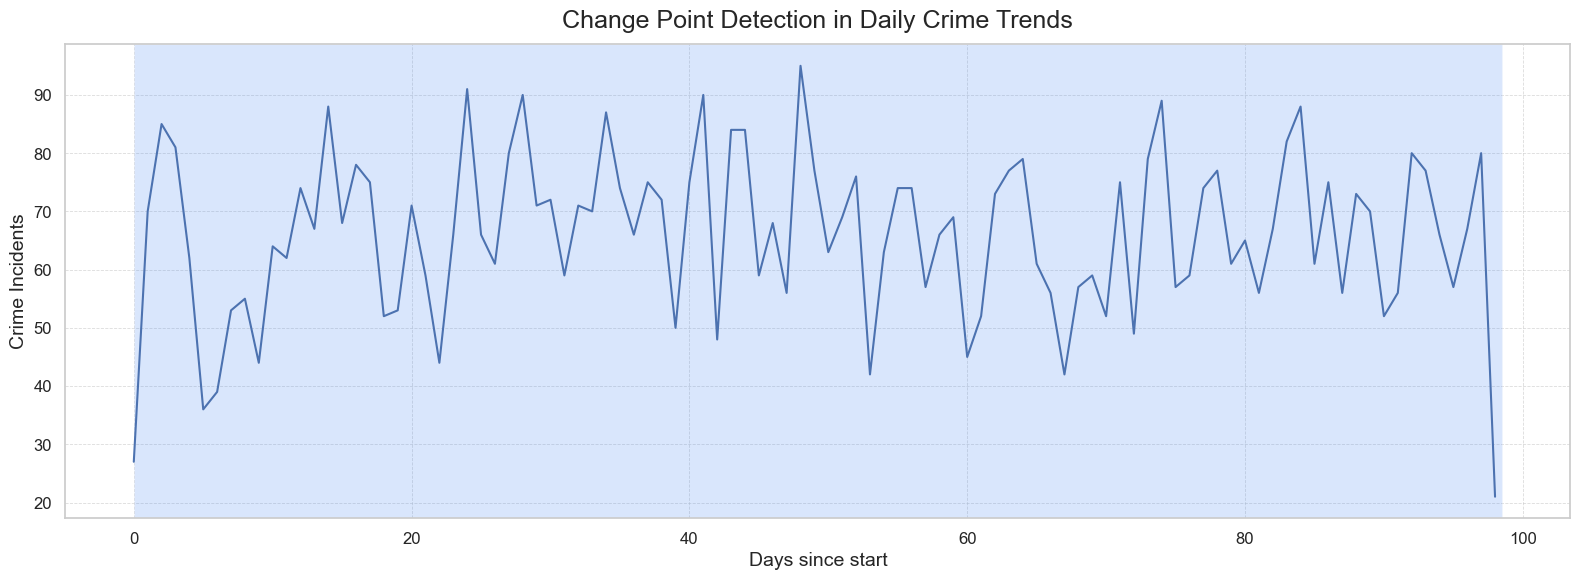

In [10]:
gdf["REPORT_DAT"] = pd.to_datetime(gdf["REPORT_DAT"])
daily_counts = gdf["REPORT_DAT"].dt.date.value_counts().sort_index()
ts = pd.Series(daily_counts.values, index=pd.to_datetime(daily_counts.index))
ts = ts.asfreq("D").fillna(0)

signal = ts.values
model = rpt.Pelt(model="rbf").fit(signal)
breaks = model.predict(pen=10)

plt.figure(figsize=(16, 6))
sns.set_style("whitegrid")
rpt.display(signal, breaks, figsize=(16, 6))

plt.title("Change Point Detection in Daily Crime Trends", fontsize=18, pad=12)
plt.xlabel("Days since start", fontsize=14)
plt.ylabel("Crime Incidents", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
plt.tight_layout()
plt.show()


## 7. Conclusions and Future Work

This analysis set out with a clear intention: to turn publicly available crime data into actionable insights by exploring the spatial and temporal dimensions of criminal activity across the United States during 2025. Using data released by the Metropolitan Police Department of the District of Columbia, the notebook applied a combination of statistical and geospatial methods to detect behavioral patterns, make short-term forecasts, and identify structural changes in crime dynamics.

Among the most revealing patterns observed was the temporal rhythm of offenses. Crime incidents spike during the evening and midnight shifts, particularly on weekdays. While perhaps unsurprising, this regularity is critical—urban life tends to slow during these hours, and public spaces become more vulnerable. The hourly breakdown adds further nuance: sharp increases during late-night and early-evening hours hint at a mix of environmental and social triggers, from reduced lighting to post-work activity clusters. Forecasting results showed a mild but steady projected rise in daily incidents, reinforcing the importance of early detection and resource planning.

On the spatial front, clustering via K-Means revealed not just crime locations but potential structural stress points in urban environments. High-density clusters were not uniformly distributed, suggesting that some neighborhoods bear a disproportionate burden of crime exposure. This unevenness is not purely geographic—it intersects with economics, infrastructure, and long-standing inequalities. Visualizing these clusters on an interactive map transforms them from abstract coordinates into areas with urgent policy relevance. These findings carry implications that go far beyond the data science domain. For instance, the observed rise in crime during specific hours may reflect deeper gaps in urban planning—perhaps areas with poor lighting, fewer patrols, or low social capital. The detection of abrupt changes in incident rates over time further hints at the influence of external events—economic shocks, political decisions, or even public health crises—all of which affect crime in ways that are not always linear or predictable.

Looking ahead, there is room to enhance this study’s scope. Merging this dataset with socioeconomic indicators, population movement data, or sentiment analysis from social platforms could unlock new layers of understanding. Technically, integrating real-time predictive models into live dashboards could support local authorities in deploying resources dynamically, adjusting strategies based on evolving data rather than historical assumptions. Citizens too have a role to play. Increasing awareness about when and where crime is more likely can help communities organize, businesses adapt, and individuals stay safer. A proactive approach to communication—through city apps, local networks, or even interactive signage—could empower neighborhoods with knowledge, not fear.Besides, for policymakers, this work points to the need for smarter infrastructure, responsive policing, and continuous evaluation of what works and what doesn’t. Crime is not static. It responds to changes in the built environment, in laws, and in people’s lives. Our strategies, if they are to be effective, must evolve just as quickly.

What this study ultimately highlights is the promise of data-driven public safety: that with the right tools and the will to act, cities can become not only more secure, but more just. The challenge is complex—but the tools, and the data, are already here.